# 3. Modelling

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import r2_score, mean_squared_error

# colors
# cmap = 'Blues'

## Loading pre-processed train and test sets

In [146]:
df_train = pd.read_csv("/content/df_train.csv", index_col=None)
df_test = pd.read_csv("/content/df_test.csv", index_col=None)

In [66]:
df_train.shape

(103904, 23)

In [67]:
df_train.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,0,13,1,2,460,3,4,3,1,5,3,5,5,4,3,3,4,5,5,25,18,0
1,1,1,25,0,0,235,3,2,3,3,1,3,1,1,1,5,2,1,4,1,1,6,0
2,0,0,26,0,0,1142,2,2,2,2,5,5,5,5,4,3,3,4,4,5,0,0,1
3,0,0,25,0,0,562,2,5,5,5,2,2,2,2,2,5,2,1,4,2,11,9,0
4,1,0,61,0,0,214,3,3,3,3,4,5,5,3,3,4,3,3,3,3,0,0,1


In [68]:
df_test.shape

(25976, 23)

In [215]:
df_test.head(5)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,0,52,0,1,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44,1
1,0,0,36,0,0,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0,1
2,1,1,20,0,1,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0,0
3,1,0,44,0,0,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6,1
4,0,0,49,0,1,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20,1


## Splitting the training and test sets beforehand

In [250]:
X_train = df_train.drop(['satisfaction'], axis=1)
y_train = df_train['satisfaction']
X_test = df_test.drop(['satisfaction'], axis=1)
y_test = df_test['satisfaction']

# Training model on smaller training and validation datasets

## Spliting the training set into smaller training and validation sets

In [240]:
from sklearn.model_selection import train_test_split
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=1)

## RandomizedSearchCV - Random Forest

Grid Search CV will be used to find the best hyperparameters of AdaBoost. However, we will apply RandomizedSearchCV for Random Forest to win time. Otherwise it may take hours.

In [222]:
#making a grid of hyperparameters for RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

grid = {"n_estimators": np.arange(10,100,10),
          "max_depth": [None,3,5,10],
          "min_samples_split": np.arange(2,20,2),
          "min_samples_leaf": np.arange(1,20,2),
          "max_features": [0.5,1,"sqrt","auto"],
          "max_samples": [10000]}

# creating a model of the RandomizedSearchCV by passing in the grid, the number of iterations(n_iter) and number of folds(cv)

model_rgs_rf = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1,
                                                   random_state=1),
                             param_distributions=grid,
                             n_iter = 10,
                             cv=5,
                             verbose=True
                              )
model_rgs_rf.fit(X_train2,y_train2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   33.7s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
best_model_rgs_rf = model_rgs_rf.best_params_

Saving the model for the future use

In [189]:
import joblib

joblib.dump(gs_model, "model_rgs_rf.pkl")

#model_gs_rf = joblib.load("/content/model_rgs_rf.pkl")

['model_rgs_rf.pkl']

## Grid Search - AdaBoost

In [258]:
from sklearn.model_selection import KFold

crossvalidation=KFold(n_splits=10,shuffle=True,random_state=1)

ada=AdaBoostClassifier()
search_grid={'n_estimators':[10, 50, 500, 2000],'learning_rate':[.001,0.01,.1]}

gs_model2=GridSearchCV(estimator=ada,param_grid=search_grid,scoring='accuracy',n_jobs=-1,cv=crossvalidation)

In [259]:
gs_model2.fit(X_train2,y_train2)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'n_estimators': [10, 50, 500, 2000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
best_gs_model2 = gs_model2.best_params_

Saving the model for the future

In [187]:
joblib.dump(gs_model2, "model_gs_abc.pkl")

#model_gs_rf = joblib.load("/content/model_gs_abc.pkl")

['model_gs_abc.pkl']

# Running models on training and validation sets with best parameters

## Precision, recall, f1-score, support
## Confusion matrix
## ROC_AUC

In [157]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, plot_confusion_matrix, plot_roc_curve
from matplotlib import pyplot as plt

## Writing a function which takes Model, test and train sets (and verbose), returns accuracy, roc_auc and time the model needs

In [209]:
def run_model2(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    
    if verbose == False:
        model.fit(X_train,y_train.ravel(), verbose=0)
    else:
        model.fit(X_train,y_train.ravel())

    y_score = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_score[:, 1]) 
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.pink, normalize = 'all')
    plot_roc_curve(model, X_test, y_test)                     
    
    return model, accuracy, roc_auc, time_taken

## Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy = 0.8609100708346166
ROC Area under Curve = 0.8760200688283842
Time taken = 2.404332160949707
              precision    recall  f1-score   support

           0    0.87668   0.87518   0.87593     14573
           1    0.84083   0.84267   0.84175     11403

    accuracy                        0.86091     25976
   macro avg    0.85876   0.85893   0.85884     25976
weighted avg    0.86094   0.86091   0.86093     25976



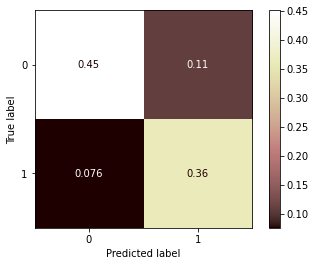

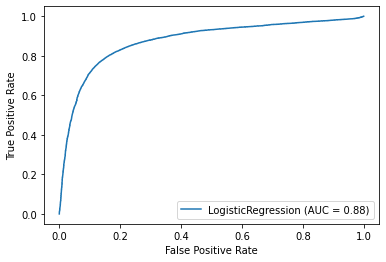

In [210]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()
model_lr, accuracy_lr, roc_auc_lr, tt_lr = run_model2(model_lr, X_train, y_train, X_test, y_test)

## Decision Tree Classifier

Accuracy = 0.8609100708346166
ROC Area under Curve = 0.9578701803358163
Time taken = 0.1706852912902832
              precision    recall  f1-score   support

           0    0.87668   0.87518   0.87593     14573
           1    0.84083   0.84267   0.84175     11403

    accuracy                        0.86091     25976
   macro avg    0.85876   0.85893   0.85884     25976
weighted avg    0.86094   0.86091   0.86093     25976



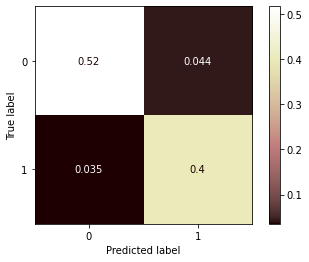

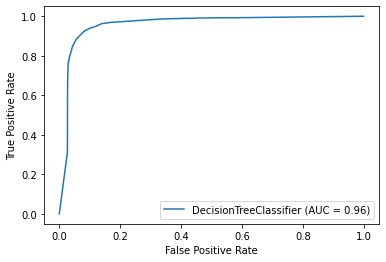

In [211]:
from sklearn.tree import DecisionTreeClassifier
params_dt = {'max_depth': 12,    
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, tt_dt = run_model2(model_dt, X_train, y_train, X_test, y_test)

## Random Forest Classifier

Accuracy = 0.8609100708346166
ROC Area under Curve = 0.9862116032588332
Time taken = 1.191061019897461
              precision    recall  f1-score   support

           0    0.87668   0.87518   0.87593     14573
           1    0.84083   0.84267   0.84175     11403

    accuracy                        0.86091     25976
   macro avg    0.85876   0.85893   0.85884     25976
weighted avg    0.86094   0.86091   0.86093     25976



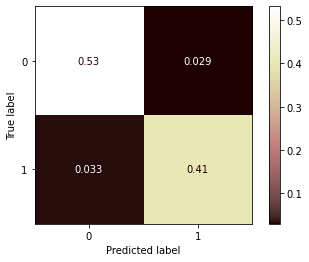

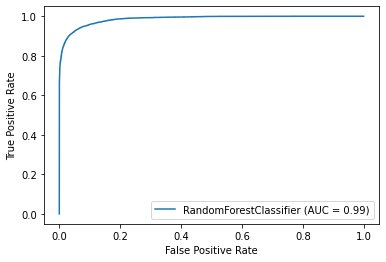

In [226]:
from sklearn.ensemble import RandomForestClassifier

params_rf = best_model_rgs_rf

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, tt_rf = run_model2(model_rf, X_train, y_train, X_test, y_test)

## AdaBoost Classifier

Accuracy = 0.8609100708346166
ROC Area under Curve = 0.9784695609235654
Time taken = 216.2799026966095
              precision    recall  f1-score   support

           0    0.87668   0.87518   0.87593     14573
           1    0.84083   0.84267   0.84175     11403

    accuracy                        0.86091     25976
   macro avg    0.85876   0.85893   0.85884     25976
weighted avg    0.86094   0.86091   0.86093     25976



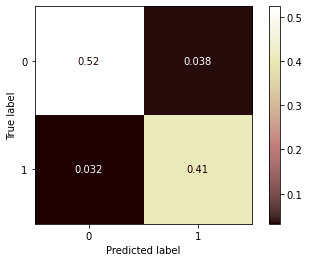

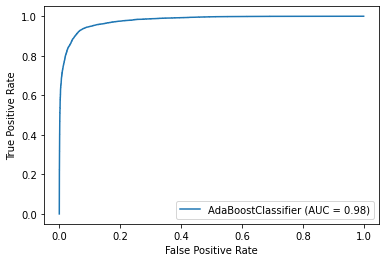

In [213]:
from sklearn.ensemble import AdaBoostClassifier as adab
params_adab = best_gs_model2 = gs_model2.best_params_

model_adab = adab(**params_adab)
model_adab, accuracy_adab, roc_auc_adab, tt_adab = run_model2(model_adab, X_train, y_train, X_test, y_test)

## Comparison of 4 models by time and ROC_AUC curve

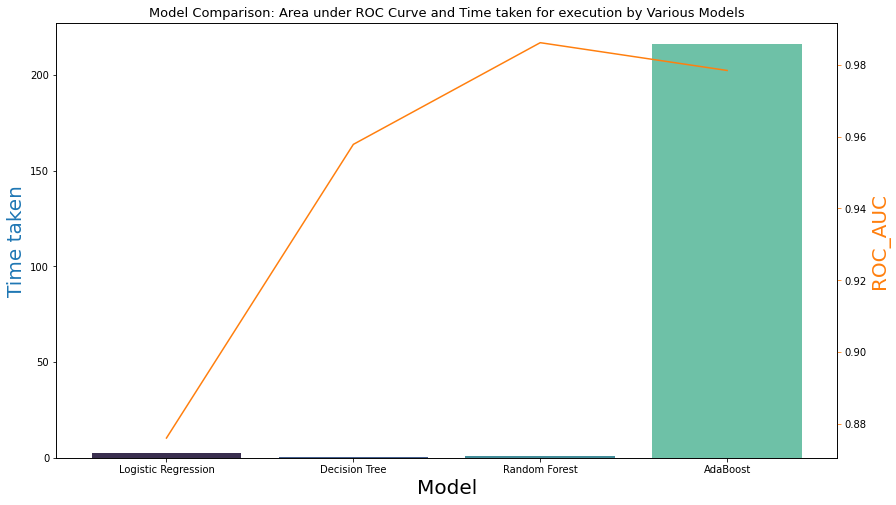

In [230]:
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_rf, roc_auc_adab]
tt = [tt_lr, tt_dt, tt_rf, tt_adab]

model_data = {'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest','AdaBoost'],
              'ROC_AUC': roc_auc_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)


fig, ax1 = plt.subplots(figsize=(14,8))
ax1.set_title('Model Comparison: Area under ROC Curve and Time taken for execution by Various Models', fontsize=13)
color = 'tab:blue'
ax1.set_xlabel('Model', fontsize=20)
ax1.set_ylabel('Time taken', fontsize=20, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='mako')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('ROC_AUC', fontsize=20, color=color)
ax2 = sns.lineplot(x='Model', y='ROC_AUC', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

# Prediction on test data

Prediction with Random Forest

In [232]:
test_preds_RFC = gs_model.predict(X_test)